In [1]:
# Sources:
# - https://towardsdatascience.com/quick-fire-guide-to-multi-modal-ml-with-openais-clip-2dad7e398ac0
# - https://huggingface.co/docs/transformers/model_doc/clip

In [2]:
import datasets
import transformers
import numpy as np
import torch
import torchvision
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

## Dataset

In [3]:
# Imagenette classes: tench, English springer, cassette player, chain saw, church, French horn, garbage truck, gas pump, golf ball, parachute
imagenette = datasets.load_dataset(
    path='frgfm/imagenette', # remote
    name='full_size',
    split='train',
    # ignore_verifications=False  # set to True if seeing splits Error
)

In [4]:
imagenette[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x281>,
 'label': 2}

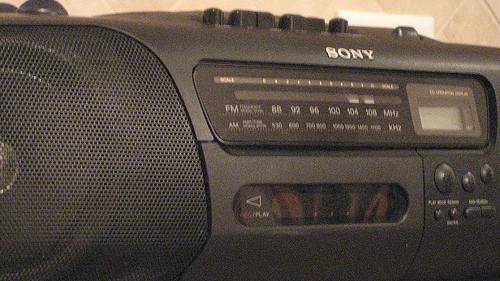

In [5]:
imagenette[0]['image']

In [6]:
# # Number of images per label
# Counter([el['label'] for el in imagenette])

In [7]:
# # Plot an example for each category
# examples = []
# for label in tqdm(range(0, 10)):
#     for el in imagenette:
#         if el['label'] == label:
#             examples.append((label, el['image']))
#             break

# exampes = sorted(examples, key=lambda el: el[0])

# for el in examples:
#     plt.figure(figsize=(5, 5))
#     plt.imshow(el[1])
#     plt.title(el[0])
#     plt.show()

In [8]:
labels = ['fish', 'dog', 'cassette_player', 'chainsaw', 'church', 'horn', 'truck', 'pump', 'golfball', 'parachute']
labels = {idx: label for idx, label in enumerate(labels)}

labels

{0: 'fish',
 1: 'dog',
 2: 'cassette_player',
 3: 'chainsaw',
 4: 'church',
 5: 'horn',
 6: 'truck',
 7: 'pump',
 8: 'golfball',
 9: 'parachute'}

## Model

In [9]:
model_id = "openai/clip-vit-base-patch32"

In [10]:
model = transformers.CLIPModel.from_pretrained(model_id)

In [11]:
# Model configs in this case are those of the model used.
model.config

CLIPConfig {
  "_name_or_path": "openai/clip-vit-base-patch32",
  "architectures": [
    "CLIPModel"
  ],
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "bos_token_id": 0,
    "dropout": 0.0,
    "eos_token_id": 2,
    "model_type": "clip_text_model"
  },
  "transformers_version": "4.33.2",
  "vision_config": {
    "dropout": 0.0,
    "model_type": "clip_vision_model"
  }
}

In [12]:
# Default configs can be create like the following.
# CLIPConfig is the configuration class to store the configuration of a CLIPModel. 
# It is used to instantiate a CLIP model according to the specified arguments, defining the text model and vision model configs. 
# Instantiating a configuration with the defaults will yield a similar configuration to that of the CLIP openai/clip-vit-base-patch32 architecture.
transformers.CLIPConfig()

CLIPConfig {
  "initializer_factor": 1.0,
  "logit_scale_init_value": 2.6592,
  "model_type": "clip",
  "projection_dim": 512,
  "text_config": {
    "model_type": "clip_text_model"
  },
  "transformers_version": "4.33.2",
  "vision_config": {
    "model_type": "clip_vision_model"
  }
}

## Compute similarity between a text and an image via embeddings

In [13]:
# Get embeddings for the text, get embedddings for the image, compute euclidean distance.

In [14]:
model = transformers.CLIPModel.from_pretrained(model_id)

In [15]:
# CLIPTokenizer is needed to process text in a format the CLIP model requires (into token IDs)
tokenizer = transformers.CLIPTokenizerFast.from_pretrained(model_id)

In [16]:
my_text = "a dog in the snow"

In [17]:
# Get text tokens ids
text_inputs = tokenizer(my_text, return_tensors="pt")
text_inputs

{'input_ids': tensor([[49406,   320,  1929,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

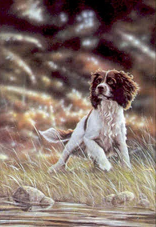

In [18]:
image = imagenette[6000]['image']
image.resize((image.width // 2, image.height // 2))

In [19]:
# A processor for images is needed to prepare them for the model, it performs resizing, normalizing, etc.
# Requires np.array, torch.tensor, or PIL images.
# Normally it is use with lists of images, therefore it returns a dict with a list
image_processor = transformers.CLIPImageProcessor.from_pretrained(model_id)
image_input = image_processor(images=np.array(image), return_tensors='pt')

print(type(image_input))
print(image_input['pixel_values'].shape)

<class 'transformers.image_processing_utils.BatchFeature'>
torch.Size([1, 3, 224, 224])


In [20]:
# NOTE: The class CLIPFeatureExtractor is deprecated and will be removed in 
# version 5 of Transformers. Please use CLIPImageProcessor instead.

In [21]:
# Get text embeddings
text_embeddings = model.get_text_features(
    input_ids=text_inputs['input_ids'], 
    attention_mask=text_inputs['attention_mask']
)

text_embeddings.shape

torch.Size([1, 512])

In [22]:
# Get image embeddings
image_embeddings = model.get_image_features(
    pixel_values=image_input['pixel_values']
)

image_embeddings.shape

torch.Size([1, 512])

In [23]:
# Compute the distance between the two embeddings vectors
def euclidean_distance(a, b):
    return torch.sqrt(torch.pow(a - b, 2).sum()).item()

euclidean_distance(text_embeddings, image_embeddings)

11.845890045166016

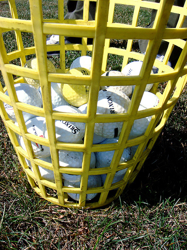

In [24]:
# For an image not showing a dog the distance is higher
image2 = imagenette[7000]['image']
image2.resize((image2.width // 2, image2.height // 2))

In [25]:
image_input2 = image_processor(images=np.array(image2), return_tensors='pt')

image_embeddings2 = model.get_image_features(
    pixel_values=image_input2['pixel_values']
)

euclidean_distance(text_embeddings, image_embeddings2)

13.197321891784668

## Compare more texts and images via a Processor

In [26]:
my_texts = [
    "a photo of a dog", 
    "a photo of a fish", 
    "a photo of a computer", 
    "a photo of a chainsaw", 
    "a photo of a music player"
]

In [27]:
# Choose some images
my_image_idxs = [0, 1000, 2500, 5000, 7000, 8000, 9000]

my_images = []
my_labels = []

for idx in my_image_idxs:
    image = np.array(imagenette[idx]['image']) # [H, W, C]
    label = imagenette[idx]['label']
    my_images.append(image)
    my_labels.append(label)

my_gts = [labels[label] for label in my_labels]

print(my_image_idxs)
print(my_labels)
print(my_gts)

[0, 1000, 2500, 5000, 7000, 8000, 9000]
[2, 0, 3, 7, 8, 6, 5]
['cassette_player', 'fish', 'chainsaw', 'pump', 'golfball', 'truck', 'horn']


In [28]:
len(my_texts), len(my_images)

(5, 7)

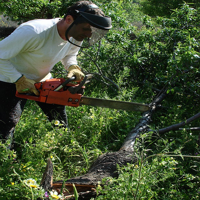

In [29]:
imagenette[2500]['image'].resize((200, 200))

In [30]:
# A CLIP Processor is a tool that prepares both text and images for the CLIP model,
# basically it's a construct that combines a CLIP tokenizer and a CLIP image processor 
# For text, it tokenizes the input (converts text into numbers, like we talked about earlier). 
# For images, it processes them into the format the CLIP model expects (like resizing, 
# cropping, normalizing pixel values, etc.).
# `from _pretrained`: this class method is simply calling CLIPImageProcessor’s from_pretrained() 
# and CLIPTokenizer’s from_pretrained(). 
processor = transformers.CLIPProcessor.from_pretrained(model_id)

In [31]:
# Use the processor to process texts and images before being input to the model.
# The internal image processor does resizing by cropping and normalization (probably other things too).
inputs = processor(
    text=my_texts,
    images=my_images, # list of np.array, torch.tensor, PIL. Must be unnormalized. Can have different shapes. 
    padding=True,
    return_tensors='pt',
)

In [32]:
# Tensor for the texts
print(inputs['input_ids'].shape)
inputs['input_ids']

torch.Size([5, 8])


tensor([[49406,   320,  1125,   539,   320,  1929, 49407, 49407],
        [49406,   320,  1125,   539,   320,  2759, 49407, 49407],
        [49406,   320,  1125,   539,   320, 11639,   652, 49407],
        [49406,   320,  1125,   539,   320, 37617, 49407, 49407],
        [49406,   320,  1125,   539,   320,  1179,  2477, 49407]])

In [33]:
# 49406: encodes the beginning of a sentence "<|startoftext|>".
# 49407: encodes the end of a sentence "<|endoftext|>".
# 320: encodes "a".
# 1929: encodes "dog".

# end of text encoding are inserted to pad the sentences to the same length.
processor.tokenizer.decode(49406), processor.tokenizer.decode(1929)

('<|startoftext|>', 'dog')

In [34]:
# Tensor for the images, resized and normalized
inputs['pixel_values'].shape

torch.Size([7, 3, 224, 224])

In [35]:
# Attention mask for the texts
# Attention=0 for the padded elements
inputs['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])

In [36]:
# Get output
outputs = model(
    input_ids=inputs['input_ids'], 
    pixel_values=inputs['pixel_values'], 
    attention_mask=inputs['attention_mask']
)

In [37]:
# Logits: absolute image-text similarity values
# H x W --> images x texts
logits_per_image = outputs.logits_per_image
logits_per_image

tensor([[21.3126, 20.8783, 26.0618, 20.3118, 33.7270],
        [20.1574, 28.7288, 17.4426, 15.8025, 18.3455],
        [17.6659, 17.4659, 18.1675, 28.5003, 20.4348],
        [19.5014, 18.5408, 22.0405, 20.2964, 23.2996],
        [19.8385, 21.1645, 20.0349, 19.7683, 21.2612],
        [19.2370, 17.4347, 21.4639, 19.8862, 20.4179],
        [17.6090, 19.5596, 21.6365, 21.8468, 24.7859]], grad_fn=<TBackward0>)

In [38]:
# To probs --> relative image-text similarity value
# probs of most similar text for each image
# Axis = 1
probs_per_image = logits_per_image.softmax(axis=1).round(decimals=2)
probs_per_image

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0200, 0.0100, 0.2100, 0.0400, 0.7300],
        [0.0900, 0.3400, 0.1100, 0.0800, 0.3700],
        [0.0600, 0.0100, 0.5900, 0.1200, 0.2100],
        [0.0000, 0.0000, 0.0400, 0.0500, 0.9100]], grad_fn=<RoundBackward1>)

In [39]:
pred_text_most_similar = probs_per_image.argmax(axis=1).numpy().tolist()
pred_text_most_similar

[4, 1, 3, 4, 4, 2, 4]

In [40]:
# Print what the image shows (GT) and the text that was found to be the most similar
for i in range(len(my_images)):
    gt = labels[my_labels[i]]
    pred = my_texts[pred_text_most_similar[i]]
    print(f'image: {my_image_idxs[i]}')
    print(f'GT: {gt}, PRED: {pred}\n')

image: 0
GT: cassette_player, PRED: a photo of a music player

image: 1000
GT: fish, PRED: a photo of a fish

image: 2500
GT: chainsaw, PRED: a photo of a chainsaw

image: 5000
GT: pump, PRED: a photo of a music player

image: 7000
GT: golfball, PRED: a photo of a music player

image: 8000
GT: truck, PRED: a photo of a computer

image: 9000
GT: horn, PRED: a photo of a music player



In [41]:
# - If an image shows something that is mentioned in one of the texts, the correct text is retrieved (AKA the correct text gets the highest similarity score).
# - If an image shows something that is NOT mentioned in one of the text, a text about something similar is retrieved (ex: for the horn image,
#   the most similar text retrieved is the text about the music player).

In [42]:
# Now get the image most similar for each text
# Axis = 0
probs_per_text = logits_per_image.softmax(axis=0).round(decimals=2)
probs_per_text

tensor([[0.5300, 0.0000, 0.9600, 0.0000, 1.0000],
        [0.1700, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.0100, 0.0000, 0.0000, 1.0000, 0.0000],
        [0.0900, 0.0000, 0.0200, 0.0000, 0.0000],
        [0.1200, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0700, 0.0000, 0.0100, 0.0000, 0.0000],
        [0.0100, 0.0000, 0.0100, 0.0000, 0.0000]], grad_fn=<RoundBackward1>)

In [43]:
pred_image_most_similar = probs_per_text.argmax(axis=0).numpy().tolist()
pred_image_most_similar

[0, 1, 0, 2, 0]

In [44]:
for i in range(len(my_texts)):
    pred_image_class = labels[my_labels[pred_image_most_similar[i]]]
    print(f'text: {my_texts[i]}')
    print(f'PRED: {pred_image_class}\n')

text: a photo of a dog
PRED: cassette_player

text: a photo of a fish
PRED: fish

text: a photo of a computer
PRED: cassette_player

text: a photo of a chainsaw
PRED: chainsaw

text: a photo of a music player
PRED: cassette_player



## Retrieve image most similar to a text

In [45]:
np.random.seed(0)
sample_idx = np.random.randint(0, len(imagenette)+1, 100).tolist()
images = [imagenette[i]['image'] for i in sample_idx]
len(images)

100

In [55]:
my_texts = ['a dog in the snow']
# my_texts = ['a creeping plant in autumn']

In [56]:
inputs = processor(
    text=my_texts,
    images=images,
    padding=True,
    return_tensors='pt',
)

In [57]:
outputs = model(
    input_ids=inputs['input_ids'], 
    pixel_values=inputs['pixel_values'], 
    attention_mask=inputs['attention_mask']
)

outputs.logits_per_image.shape

torch.Size([100, 1])

In [58]:
most_similar_image_idx = outputs.logits_per_image.argmax(axis=0).item()
most_similar_image_idx

71

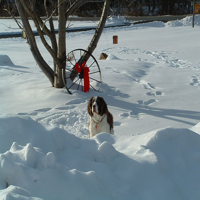

In [59]:
most_similar_image = images[most_similar_image_idx]
most_similar_image.resize((200, 200))

In [60]:
# Check the other images in the top 3
logits, idxs = torch.sort(outputs.logits_per_image, axis=0, descending=True)
logits.shape, idxs.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [61]:
top3_idxs = idxs[:3].reshape(3).numpy().tolist()
top3_idxs

[71, 24, 86]

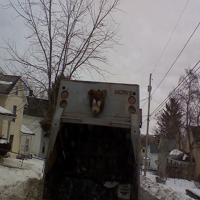

In [62]:
images[top3_idxs[1]].resize((200, 200))

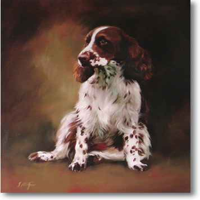

In [63]:
images[top3_idxs[2]].resize((200, 200))